In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_csv("bitcoin.csv")
df.head()

,timestamp,prices,market_caps,total_volumes
0,2013-04-28 00:00:00.000,135.30,1.500518e+09,0.0
1,2013-04-29 00:00:00.000,141.96,1.575032e+09,0.0
2,2013-04-30 00:00:00.000,135.30,1.501657e+09,0.0
3,2013-05-01 00:00:00.000,117.00,1.298952e+09,0.0
4,2013-05-02 00:00:00.000,103.43,1.148668e+09,0.0


In [44]:
# 100x logged returns
df['log_returns'] = np.log(df['prices']) - np.log(df['prices']).shift(1)
df['log_returns_scaled'] = np.multiply(df['returns'], 100)

In [6]:
returns = pd.DataFrame(df['returns'].dropna())

(array([1.000e+00, 0.000e+00, 3.000e+00, 1.400e+01, 1.130e+02, 1.572e+03,
        1.974e+03, 1.350e+02, 1.400e+01, 1.000e+00]),
 array([-0.43371443, -0.36163308, -0.28955173, -0.21747037, -0.14538902,
        -0.07330767, -0.00122632,  0.07085503,  0.14293638,  0.21501774,
         0.28709909]),
 <BarContainer object of 10 artists>)

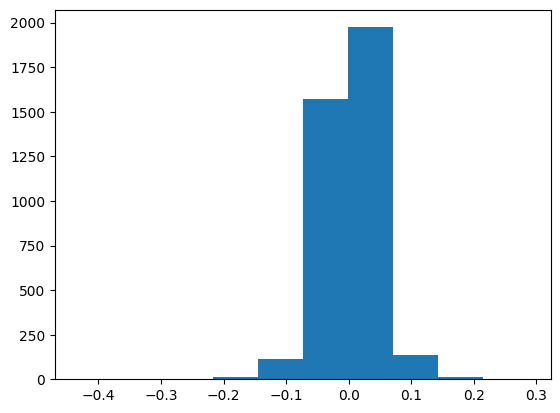

In [7]:
plt.hist(returns['returns'])

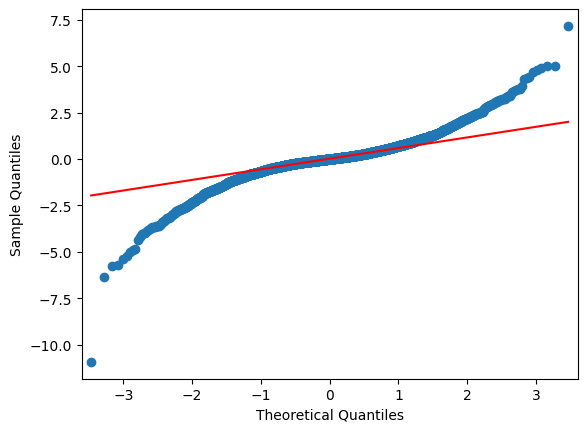

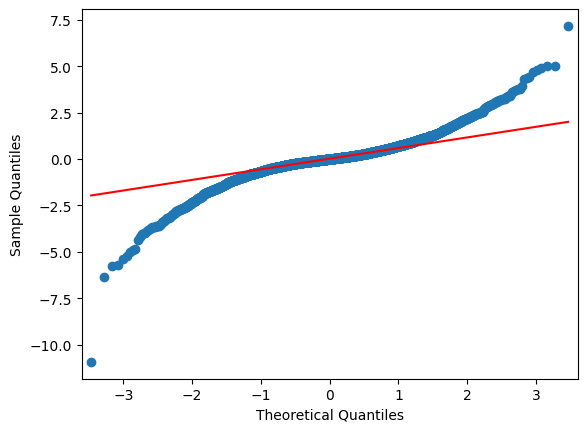

In [8]:
qqplot(returns['returns'], line='q', fit=True)

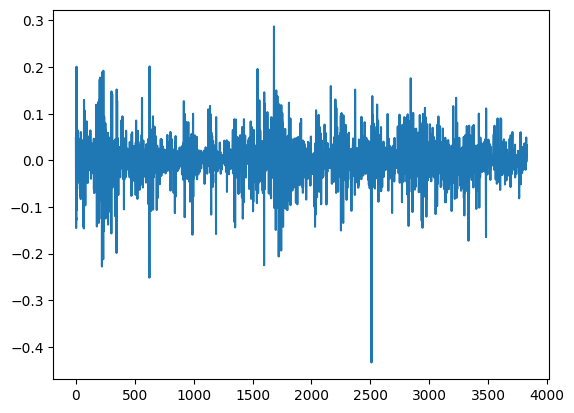

In [9]:
plt.plot(returns['returns'])

In [63]:
df = df.dropna(subset=['log_returns'])

def recursive_forecast(log_returns, window):
    forecasts = {}
    log_returns = df['log_returns']
    for i in range(window, len(log_returns)):
        model = arch_model(log_returns[:i], mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = model.fit(disp='off')

        forecast = model_fit.forecast(horizon=1)
        forecasts[log_returns.index[i]] = forecast.variance.iloc[-1, 0]

    return pd.DataFrame(forecasts, index=['Forecast']).T

window = 5

forecast_results = recursive_forecast(df, window)


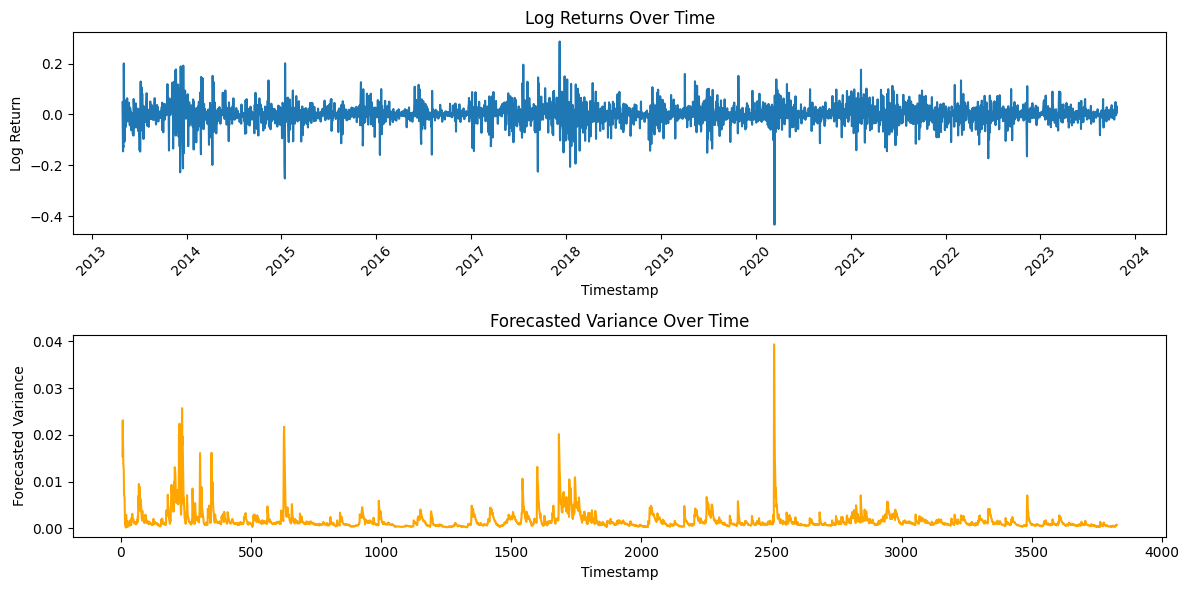

In [59]:

import matplotlib.dates as mdates
df['timestamp'] = pd.to_datetime(df['timestamp'])

plt.figure(figsize=(12, 6))

# Plotting log returns
plt.subplot(2, 1, 1)
plt.plot(df['timestamp'], df['log_returns'], label='Log Returns')
plt.title('Log Returns Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Log Return')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show one label per year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format labels as years
plt.xticks(rotation=45)  # Rotate labels


# Plotting forecasted variance
plt.subplot(2, 1, 2)
plt.plot(forecast_results.index, forecast_results, label='Forecasted Variance', color='orange')
plt.title('Forecasted Variance Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Forecasted Variance')

plt.tight_layout()
plt.show()

In [62]:
model = arch_model(df['log_returns'], mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7329.94
Distribution:                  Normal   AIC:                          -14653.9
Method:            Maximum Likelihood   BIC:                          -14635.1
                                        No. Observations:                 3827
Date:                Sun, Nov 12 2023   Df Residuals:                     3827
Time:                        15:22:03   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.1681e-05  3.626e-06      8.737  2.400e-18 [2.457e-05,3.879e-05]
alpha[1]       0.1000  2.205e-02      4.535  5.760e-06   [5.678e-02,  0.143]
beta[1]        0.8800  1.815e-02     48.497      0.000     [  0.844,  0.916]
============================================================================

Covariance estimator: robust
"""